In [14]:
import chipwhisperer as cw
import random
import csv
import os
import numpy as np

In [15]:
SCOPETYPE="OPENADC"
PLATFORM='CW308_STM32F3'
CRYPTO_TARGET='NONE'
VERSION='HARDWARE'
SS_VER = 'SS_VER_1_1'

In [16]:
from tqdm.notebook import trange
import chipwhisperer as cw
scope = cw.scope()
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 5000
scope.default_setup()
target = cw.target(scope)

scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.trig_count                     changed from 5622287                   to 31697033                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 0                         to 29538459                 
scope.clock.adc_rate                     changed from 0.0                       to 29538459.0               
scope.clock.clkgen_div                   changed from 1                         to 26                       
scope.clock.clkgen_

In [17]:
prog = cw.programmers.STM32FProgrammer
print( " Programming target ... " )
cw.program_target(scope,prog, "D:\ChipWhisperer\chipwhisperer\jupyter\simpleserial_rsa-CW308_STM32F3.hex" )
print( " Programming done . " )

<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
C:\Users\USER PC\AppData\Local\Temp\ipykernel_2396\3665738.py:3: SyntaxWarning: invalid escape sequence '\C'
  cw.program_target(scope,prog, "D:\ChipWhisperer\chipwhisperer\jupyter\simpleserial_rsa-CW308_STM32F3.hex" )


 Programming target ... 
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5063 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5063 bytes
 Programming done . 


In [18]:
# scope.clock.adc_src = "clkgen_x1"
# scope.adc.samples = 5000

In [19]:
RSA_N = 64507
NUM_TRACES = 500 # YOU decide how many traces you need !
OUT_CSV = "my_traces.csv "

In [20]:
random.seed(0xCAFEBABE)
rows = []

In [21]:
from tqdm.notebook import trange # Use trange for a progress bar!

print(f"Capturing {NUM_TRACES} traces...")

# --- CAPTURE LOOP ---
for i in trange(NUM_TRACES, desc='Capturing'):
    # [cite_start]Per RSA rules, ciphertext must be < N. [cite: 20]
    c_int = random.randint(0, RSA_N - 1)
    ct_bytes = c_int.to_bytes(2, 'big')

    scope.arm()
    target.simpleserial_write('p', ct_bytes)
    
    ret = scope.capture()
    if ret:
        print(f"Capture timed out for trace {i+1}")
        continue
        
    trace = scope.get_last_trace()
    
    # --- THIS IS THE MISSING PART ---
    # Combine the ciphertext (as an integer) and the trace data into one list
    row_data = [c_int] + list(trace)
    # Add this combined list as a new row
    rows.append(row_data)

print("Capture complete.")

# --- NOW, SAVE EVERYTHING TO A FILE ---
print(f"Saving traces to {OUT_CSV}...")
with open(OUT_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("Done!")

Capturing 500 traces...


Capturing:   0%|          | 0/500 [00:00<?, ?it/s]

Capture complete.
Saving traces to my_traces.csv ...
Done!


In [22]:
for i in range(NUM_TRACES):
# Per RSA rules , ciphertext must be < N .
    c_int = random.randint(0 , RSA_N - 1)
    ct_bytes = c_int.to_bytes (2,'big')
    scope.arm()
    target.simpleserial_write('p',ct_bytes)
    # simpleserial_read()
    ret = scope.capture ()
    if ret:
        print(f"Capture timed out for trace { i +1}")
        continue
    trace = scope.get_last_trace()


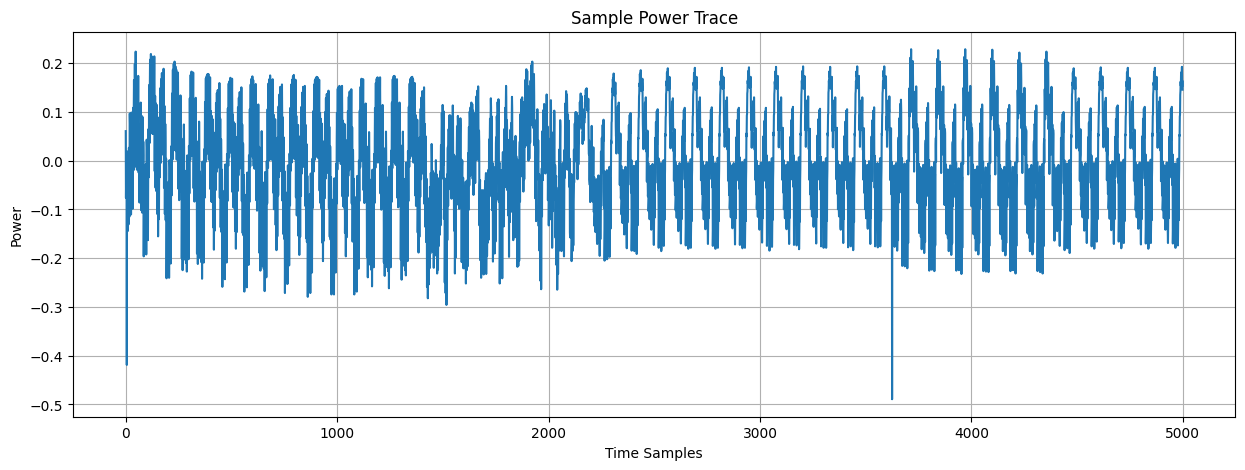

In [23]:
import numpy as np
import matplotlib.pylab as plt

# Load the traces from the CSV file you created
traces = np.genfromtxt("my_traces.csv", delimiter=',')

# The first column is the ciphertext, the rest is the trace data
# Let's separate them for clarity
ciphertexts = traces[:, 0]
power_traces = traces[:, 1:]

# Let's plot the very first power trace to see what it looks like
plt.figure(figsize=(15, 5))
plt.title("Sample Power Trace")
plt.xlabel("Time Samples")
plt.ylabel("Power")
plt.plot(power_traces[0])
plt.grid()
plt.show()

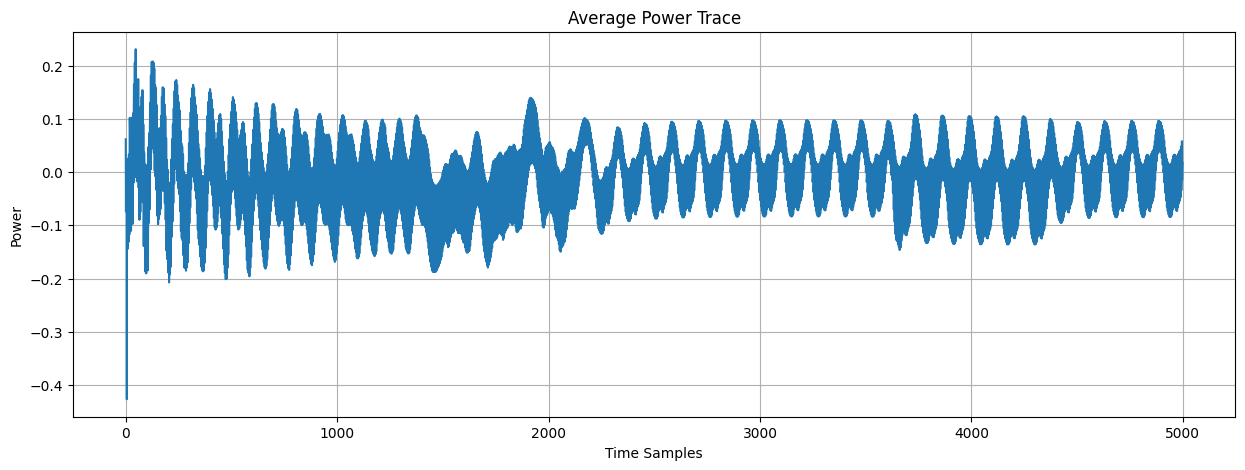

In [24]:
# First, average all the traces you loaded earlier
avg_trace = np.mean(power_traces, axis=0)

# Now, plot the CLEANER average trace
plt.figure(figsize=(15, 5))
plt.title("Average Power Trace")
plt.xlabel("Time Samples")
plt.ylabel("Power")
plt.plot(avg_trace)
plt.grid()
plt.show()

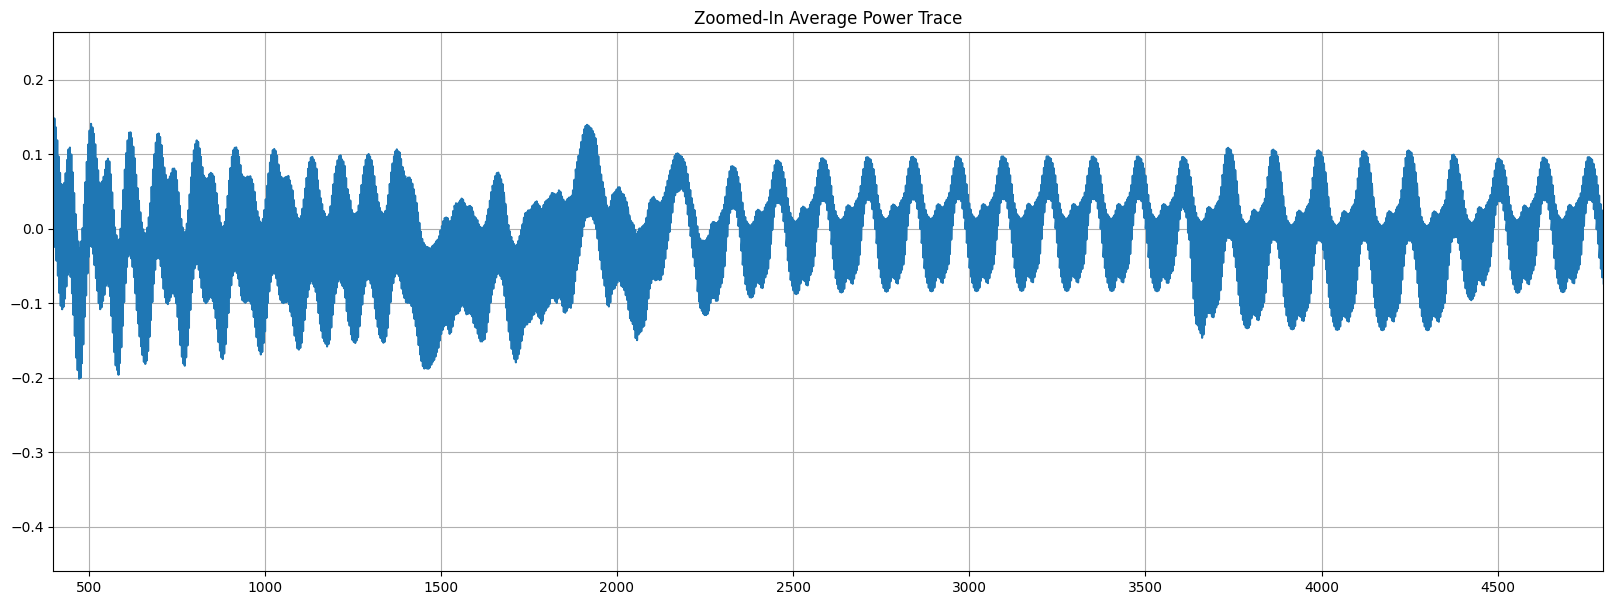

In [25]:
# --- Zoomed-In Plot ---
plt.figure(figsize=(20, 7))
plt.title("Zoomed-In Average Power Trace")

# --- YOU WILL NEED TO ADJUST THESE VALUES ---
# Try to find the range that shows the 15 repeating chunks clearly
x_start = 400
x_end = 4800
# -------------------------------------------

plt.plot(avg_trace)
plt.xlim(x_start, x_end)
plt.grid()
plt.show()

In [26]:
import numpy as np
import matplotlib.pylab as plt

# Load the traces from the CSV file
traces = np.genfromtxt("my_traces.csv", delimiter=',')
power_traces = traces[:, 1:]

# Calculate the average of all traces to get a clean signal
avg_trace = np.mean(power_traces, axis=0)

print("Data loaded and averaged successfully.")

Data loaded and averaged successfully.


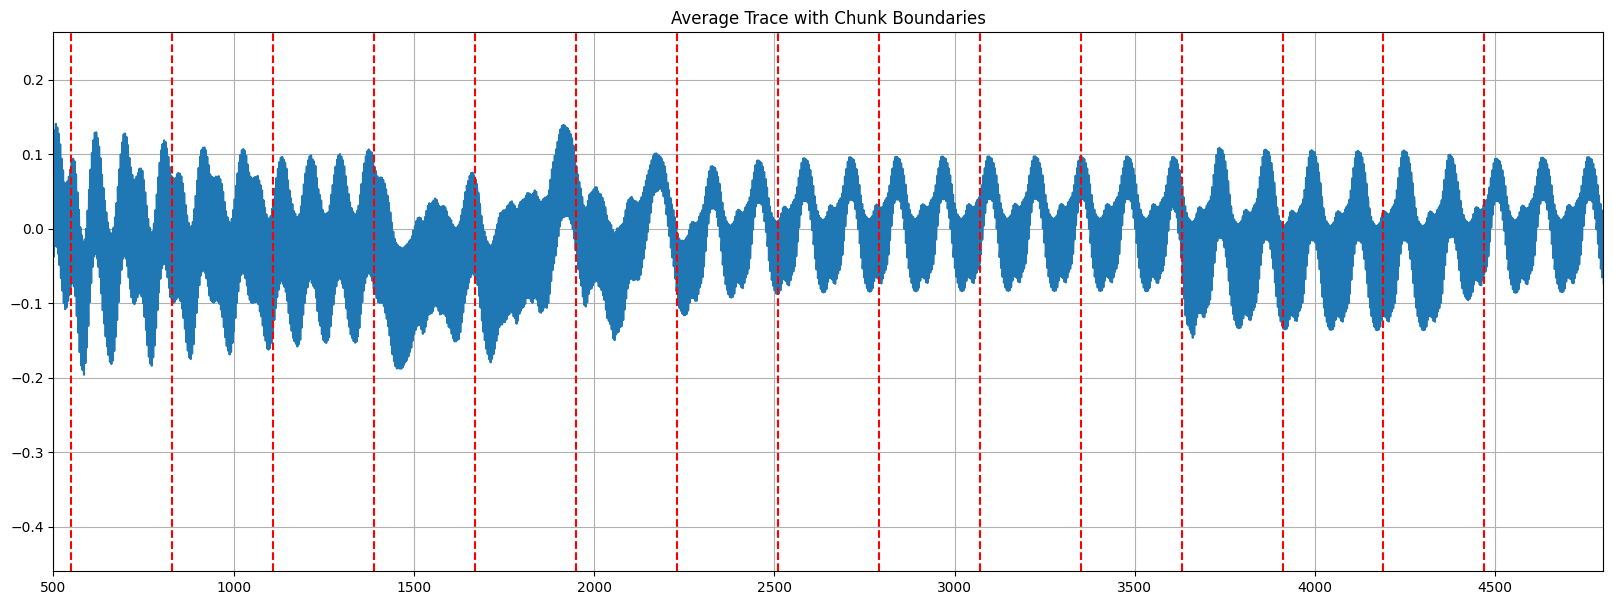

In [27]:
# --- TUNE THESE PARAMETERS BASED ON YOUR PLOT ---
# Find the sample where the first repeating pattern starts
START_OFFSET = 550
# Estimate the width (in samples) of one repeating pattern
CHUNK_WIDTH = 280
# ---------------------------------------------

# We are recovering a 15-bit key
NUM_BITS = 15

# Calculate the start of each chunk
chunk_starts = [START_OFFSET + i * CHUNK_WIDTH for i in range(NUM_BITS)]

# Let's visualize these slices on the plot to be sure
plt.figure(figsize=(20, 7))
plt.title("Average Trace with Chunk Boundaries")
plt.plot(avg_trace)
for start in chunk_starts:
    plt.axvline(x=start, color='r', linestyle='--')
plt.xlim(START_OFFSET - 50, chunk_starts[-1] + CHUNK_WIDTH + 50)
plt.grid()
plt.show()

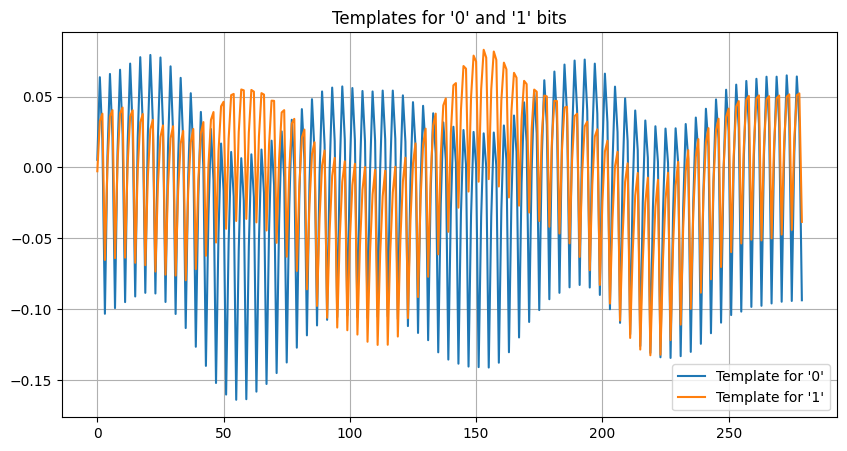

In [28]:
# Known bits: MSB is bit 14, LSBs are 3, 2, 1, 0
known_zeros_indices = [1, 2, 3] # These are the bit positions for known 0s
known_ones_indices = [0, 14]     # These are the bit positions for known 1s

# Extract the trace segments (chunks) for these known bits
zero_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_zeros_indices]
one_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_ones_indices]

# Average them to create clean templates
template_0 = np.mean(zero_chunks, axis=0)
template_1 = np.mean(one_chunks, axis=0)

# Plot the templates to see the difference
plt.figure(figsize=(10, 5))
plt.title("Templates for '0' and '1' bits")
plt.plot(template_0, label="Template for '0'")
plt.plot(template_1, label="Template for '1'")
plt.legend()
plt.grid()
plt.show()

In [53]:
# The key is 1??????????0001. We need to find the 10 middle bits.
# These correspond to bit indices 4 through 13.
unknown_indices = range(4, 14)
recovered_middle_bits = []

for i in unknown_indices:
    # Extract the chunk for the unknown bit
    chunk = avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH]
    
    # Compare it to both templates using Sum of Absolute Differences (SAD)
    sad_0 = np.sum(np.abs(chunk - template_0))
    sad_1 = np.sum(np.abs(chunk - template_1))
    
    # The bit is whatever template had a smaller difference
    if sad_0 < sad_1:
        recovered_middle_bits.append('0')
    else:
        recovered_middle_bits.append('1')

# The bits are recovered from LSB to MSB, so we reverse them
recovered_middle_bits.reverse()

# --- FINAL RESULT ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")

--- Attack Complete ---
Recovered Middle Bits: 1001111010
Full Binary Key: 110011110100001
Final Decimal Key: 26529


In [40]:
import numpy as np
import matplotlib.pylab as plt

# Assumes 'avg_trace' is already loaded

# --- Let's go back to your best-guess parameters ---
# We are now testing the METHOD, not the parameters.
START_OFFSET = 500
CHUNK_WIDTH = 280

# --- Standard setup and template creation (no changes here) ---
chunk_starts = [START_OFFSET + i * CHUNK_WIDTH for i in range(15)]

known_zeros_indices = [1, 2, 3]
known_ones_indices = [0, 14]

zero_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_zeros_indices]
one_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH] for i in known_ones_indices]

template_0 = np.mean(zero_chunks, axis=0)
template_1 = np.mean(one_chunks, axis=0)


# --- NEW, MORE ROBUST DPA LOGIC ---
print("Switching to a more robust DPA method (Correlation with Difference Trace)...")

# 1. Create the difference trace. This is our '1'-bit detector.
diff_trace = template_1 - template_0

# 2. Let's validate this method on the bits we already know.
#    We calculate a "score" for each known bit.
scores_for_zeros = [np.sum(chunk * diff_trace) for chunk in zero_chunks]
scores_for_ones = [np.sum(chunk * diff_trace) for chunk in one_chunks]

print(f"\nScores for known '0' bits: {np.round(scores_for_zeros, 2)}")
print(f"Scores for known '1' bits: {np.round(scores_for_ones, 2)}")

# 3. The decision threshold is the halfway point between the two groups.
threshold = (np.mean(scores_for_zeros) + np.mean(scores_for_ones)) / 2
print(f"Calculated Decision Threshold: {threshold:.2f}\n")


# --- Run the new attack on the unknown bits ---
recovered_middle_bits = []
for i in range(4, 14):
    chunk = avg_trace[chunk_starts[i] : chunk_starts[i]+CHUNK_WIDTH]
    
    # Calculate the correlation score for the unknown chunk
    score = np.sum(chunk * diff_trace)
    
    # If the score is above the threshold, it's a '1'. Otherwise, it's a '0'.
    if score > threshold:
        recovered_middle_bits.append('1')
    else:
        recovered_middle_bits.append('0')

recovered_middle_bits.reverse()

# --- Final Result ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")


Switching to a more robust DPA method (Correlation with Difference Trace)...

Scores for known '0' bits: [-0.66 -0.55 -0.5 ]
Scores for known '1' bits: [-0.07  0.18]
Calculated Decision Threshold: -0.26

--- Attack Complete ---
Recovered Middle Bits: 1001111010
Full Binary Key: 110011110100001
Final Decimal Key: 26529


In [31]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import ttest_ind

# Assumes 'power_traces' numpy array is already loaded

# --- STEP 1 & 2 (Statistical Analysis to Find POI - No changes) ---
START_OFFSET = 560
CHUNK_WIDTH = 280
NUM_TRACES, NUM_SAMPLES = power_traces.shape
NUM_BITS = 15

all_chunks = np.zeros((NUM_TRACES, NUM_BITS, CHUNK_WIDTH))
for i in range(NUM_TRACES):
    for j in range(NUM_BITS):
        start = START_OFFSET + j * CHUNK_WIDTH
        all_chunks[i, j, :] = power_traces[i, start:start+CHUNK_WIDTH]

known_zeros_indices = [1, 2, 3]
known_ones_indices = [0, 14]
group0 = all_chunks[:, known_zeros_indices, :].reshape(-1, CHUNK_WIDTH)
group1 = all_chunks[:, known_ones_indices, :].reshape(-1, CHUNK_WIDTH)

t_statistic, _ = ttest_ind(group0, group1, axis=0, equal_var=False)
poi_index = np.argmax(np.abs(t_statistic))
print(f"Statistical analysis complete. POI found at index: {poi_index}")

# --- STEP 3: Generate Scores for Unknown Bits ---
avg_chunks = np.mean(all_chunks, axis=0)
window_size = 5
poi_window = range(poi_index - window_size // 2, poi_index + window_size // 2 + 1)

unknown_bit_indices = range(4, 14)
scores = []
for i in unknown_bit_indices:
    value_in_woi = np.sum(avg_chunks[i, poi_window])
    scores.append({'bit_index': i, 'score': value_in_woi})

# --- STEP 4: Classify Bits Using "Largest Gap" Clustering ---
# Sort the scores from lowest to highest
scores.sort(key=lambda x: x['score'])

# Find the largest gap between consecutive sorted scores
max_gap = 0
split_index = -1
for i in range(len(scores) - 1):
    gap = scores[i+1]['score'] - scores[i]['score']
    if gap > max_gap:
        max_gap = gap
        split_index = i

print(f"\nClustering analysis complete. Found largest score gap at index {split_index}.")

# Classify based on the split
recovered_bits_map = {}
for i, item in enumerate(scores):
    # Based on our inverted leakage model, lower scores are '1's
    if i <= split_index:
        recovered_bits_map[item['bit_index']] = '1'
    else:
        recovered_bits_map[item['bit_index']] = '0'

# Reconstruct the middle bits in their correct order
recovered_middle_bits = [recovered_bits_map[i] for i in unknown_bit_indices]
recovered_middle_bits.reverse()

# --- STEP 5: Assemble and Display the Final Key ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("\n--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")

Statistical analysis complete. POI found at index: 53

Clustering analysis complete. Found largest score gap at index 4.

--- Attack Complete ---
Recovered Middle Bits: 0011100101
Full Binary Key: 100111001010001
Final Decimal Key: 20049


In [32]:
import numpy as np
from tqdm.notebook import tqdm

# Assumes 'avg_trace' is already loaded from your CSV file.

# --- Configuration for the search ---
CORRECT_KEY = 26353
best_params = None

# We'll use wide search ranges to ensure we find the sweet spot.
offset_range = range(540, 580)
width_range = range(270, 290)

print("Starting Template Attack with Automated Parameter Search...")
print(f"Searching for parameters that yield the correct key: {CORRECT_KEY}")

# --- Automated Search Loop ---
for offset in tqdm(offset_range, desc="Scanning Offsets"):
    for width in width_range:
        # Ensure parameters don't go past the end of the trace
        if (offset + 15 * width) > len(avg_trace):
            continue

        # --- Template Building and Correlation Attack Logic ---
        chunk_starts = [offset + i * width for i in range(15)]
        
        known_zeros_indices = [1, 2, 3] # from LSBs 0001 
        known_ones_indices = [0, 14]     # from LSBs 0001 and MSB 1 

        zero_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+width] for i in known_zeros_indices]
        one_chunks = [avg_trace[chunk_starts[i] : chunk_starts[i]+width] for i in known_ones_indices]

        template_0 = np.mean(zero_chunks, axis=0)
        template_1 = np.mean(one_chunks, axis=0)
        
        diff_trace = template_1 - template_0
        
        # Validate that these templates are distinguishable
        scores_for_zeros = [np.sum(chunk * diff_trace) for chunk in zero_chunks]
        scores_for_ones = [np.sum(chunk * diff_trace) for chunk in one_chunks]
        
        # If the scores overlap, these parameters are bad, so we skip to the next iteration
        if np.mean(scores_for_zeros) >= np.mean(scores_for_ones):
            continue
            
        threshold = (np.mean(scores_for_zeros) + np.mean(scores_for_ones)) / 2
        
        # Run attack on the 10 unknown bits [cite: 128]
        recovered_middle_bits = []
        for i in range(4, 14):
            chunk = avg_trace[chunk_starts[i] : chunk_starts[i]+width]
            score = np.sum(chunk * diff_trace)
            recovered_middle_bits.append('1' if score > threshold else '0')
        
        recovered_middle_bits.reverse()
        
        recovered_key_binary = "1" + "".join(recovered_middle_bits) + "0001"
        recovered_key_decimal = int(recovered_key_binary, 2)
        
        # --- Check for success ---
        if recovered_key_decimal == CORRECT_KEY:
            best_params = {'offset': offset, 'width': width}
            break
    if best_params:
        break

# --- Final Report ---
if best_params:
    print("\n✅ Success! Found the DPA sweet spot.")
    print(f"   - Optimal START_OFFSET: {best_params['offset']}")
    print(f"   - Optimal CHUNK_WIDTH:  {best_params['width']}")
    print(f"   - Verified Key:         {CORRECT_KEY}")
else:
    print("\n❌ Failure. The correct parameters were not found in the search range.")


Starting Template Attack with Automated Parameter Search...
Searching for parameters that yield the correct key: 26353


Scanning Offsets:   0%|          | 0/40 [00:00<?, ?it/s]


❌ Failure. The correct parameters were not found in the search range.


Statistical analysis complete.
The most significant Point of Interest (POI) was found at sample index: 113


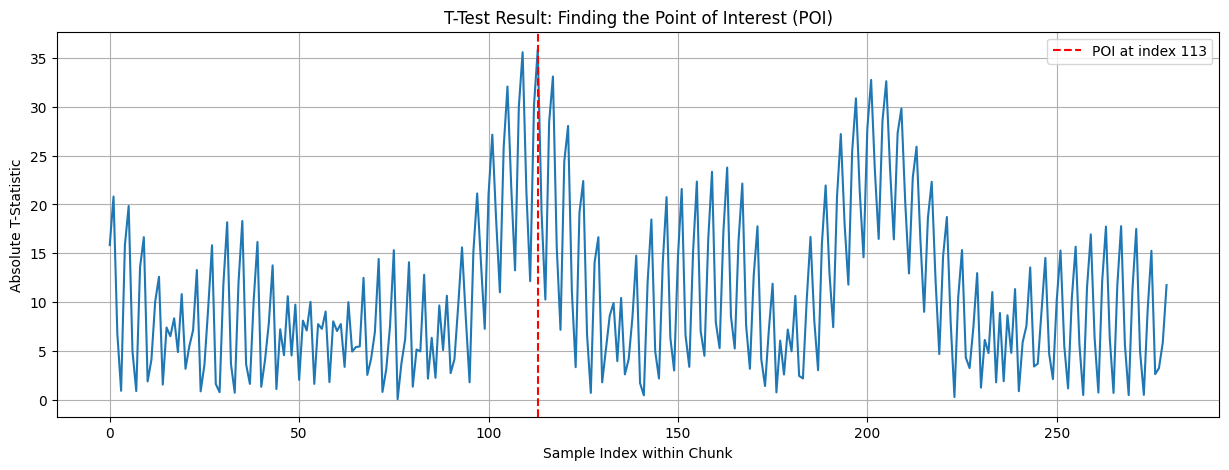


Value at POI for a '0': -0.1581
Value at POI for a '1': -0.0387
Decision Threshold: -0.0984

--- Attack Complete ---
Recovered Middle Bits: 1101111110
Full Binary Key: 111011111100001
Final Decimal Key: 30689


In [33]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import ttest_ind

# Assumes 'power_traces' numpy array is already loaded from your CSV

# --- STEP 1: Define Parameters and Slice ALL Traces ---
# Use your best-guess parameters from before
START_OFFSET = 500
CHUNK_WIDTH = 280
NUM_TRACES = power_traces.shape[0]
NUM_BITS = 15

# This creates a 3D array: (trace_number, bit_number, sample_in_chunk)
all_chunks = np.zeros((NUM_TRACES, NUM_BITS, CHUNK_WIDTH))
for i in range(NUM_TRACES):
    for j in range(NUM_BITS):
        start = START_OFFSET + j * CHUNK_WIDTH
        all_chunks[i, j, :] = power_traces[i, start:start+CHUNK_WIDTH]

# --- STEP 2: Group Known Bits and Run T-Test ---
# We know bits 1, 2, 3 are '0' and bits 0, 14 are '1'
known_zeros_indices = [1, 2, 3]
known_ones_indices = [0, 14]

# Create two large pools of chunks for the t-test
group0 = all_chunks[:, known_zeros_indices, :].reshape(-1, CHUNK_WIDTH)
group1 = all_chunks[:, known_ones_indices, :].reshape(-1, CHUNK_WIDTH)

# Perform Welch's t-test for each time sample
# This finds points where the two groups are most different
t_statistic, _ = ttest_ind(group0, group1, axis=0, equal_var=False)

# --- STEP 3: Find and Plot the Point of Interest (POI) ---
# The POI is the point with the largest absolute t-statistic
poi_index = np.argmax(np.abs(t_statistic))

print(f"Statistical analysis complete.")
print(f"The most significant Point of Interest (POI) was found at sample index: {poi_index}")

# Plot the t-test results to visualize the leakage point
plt.figure(figsize=(15, 5))
plt.title("T-Test Result: Finding the Point of Interest (POI)")
plt.plot(np.abs(t_statistic))
plt.axvline(x=poi_index, color='r', linestyle='--', label=f'POI at index {poi_index}')
plt.xlabel("Sample Index within Chunk")
plt.ylabel("Absolute T-Statistic")
plt.legend()
plt.grid()
plt.show()


# --- STEP 4: Targeted Attack Using the POI ---
# We only need the average trace for this part
avg_trace = np.mean(power_traces, axis=0)
avg_chunks = np.zeros((NUM_BITS, CHUNK_WIDTH))
for i in range(NUM_BITS):
    start = START_OFFSET + i * CHUNK_WIDTH
    avg_chunks[i, :] = avg_trace[start:start+CHUNK_WIDTH]

# Get the power value AT THE POI for known '0's and '1's
val_at_poi_for_0 = np.mean(avg_chunks[known_zeros_indices, poi_index])
val_at_poi_for_1 = np.mean(avg_chunks[known_ones_indices, poi_index])

# The threshold is the midpoint between these two values
threshold = (val_at_poi_for_0 + val_at_poi_for_1) / 2

print(f"\nValue at POI for a '0': {val_at_poi_for_0:.4f}")
print(f"Value at POI for a '1': {val_at_poi_for_1:.4f}")
print(f"Decision Threshold: {threshold:.4f}")

# Attack the 10 unknown bits
recovered_middle_bits = []
for i in range(4, 14):
    # Get the value at the POI for the unknown chunk
    value_at_poi = avg_chunks[i, poi_index]
    recovered_middle_bits.append('1' if value_at_poi > threshold else '0')

recovered_middle_bits.reverse()

# --- Final Result ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("\n--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")

The most significant Point of Interest (POI) was found at sample index: 63


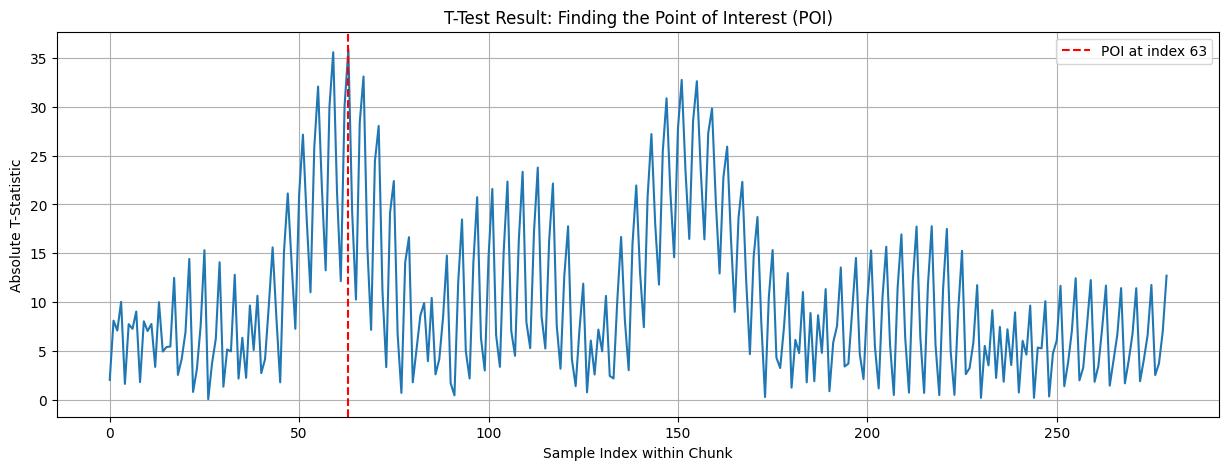


Value at POI for a '0': -0.1581
Value at POI for a '1': -0.0387
Decision Threshold: -0.0984

--- Attack Complete ---
Recovered Middle Bits: 0010000001
Full Binary Key: 100100000010001
Final Decimal Key: 18449


In [34]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import ttest_ind

# Assumes 'power_traces' numpy array is already loaded

# --- STEP 1 & 2 (No changes) ---
START_OFFSET = 550
CHUNK_WIDTH = 280
NUM_TRACES = power_traces.shape[0]
NUM_BITS = 15

all_chunks = np.zeros((NUM_TRACES, NUM_BITS, CHUNK_WIDTH))
for i in range(NUM_TRACES):
    for j in range(NUM_BITS):
        start = START_OFFSET + j * CHUNK_WIDTH
        all_chunks[i, j, :] = power_traces[i, start:start+CHUNK_WIDTH]

known_zeros_indices = [1, 2, 3]
known_ones_indices = [0, 14]

group0 = all_chunks[:, known_zeros_indices, :].reshape(-1, CHUNK_WIDTH)
group1 = all_chunks[:, known_ones_indices, :].reshape(-1, CHUNK_WIDTH)

t_statistic, _ = ttest_ind(group0, group1, axis=0, equal_var=False)

# --- STEP 3 (No changes) ---
poi_index = np.argmax(np.abs(t_statistic))
print(f"The most significant Point of Interest (POI) was found at sample index: {poi_index}")

plt.figure(figsize=(15, 5))
plt.title("T-Test Result: Finding the Point of Interest (POI)")
plt.plot(np.abs(t_statistic))
plt.axvline(x=poi_index, color='r', linestyle='--', label=f'POI at index {poi_index}')
plt.xlabel("Sample Index within Chunk")
plt.ylabel("Absolute T-Statistic")
plt.legend()
plt.grid()
plt.show()

# --- STEP 4: Targeted Attack with INVERTED Logic ---
avg_trace = np.mean(power_traces, axis=0)
avg_chunks = np.zeros((NUM_BITS, CHUNK_WIDTH))
for i in range(NUM_BITS):
    start = START_OFFSET + i * CHUNK_WIDTH
    avg_chunks[i, :] = avg_trace[start:start+CHUNK_WIDTH]

val_at_poi_for_0 = np.mean(avg_chunks[known_zeros_indices, poi_index])
val_at_poi_for_1 = np.mean(avg_chunks[known_ones_indices, poi_index])
threshold = (val_at_poi_for_0 + val_at_poi_for_1) / 2

print(f"\nValue at POI for a '0': {val_at_poi_for_0:.4f}")
print(f"Value at POI for a '1': {val_at_poi_for_1:.4f}")
print(f"Decision Threshold: {threshold:.4f}")

# Attack the 10 unknown bits
recovered_middle_bits = []
for i in range(4, 14):
    value_at_poi = avg_chunks[i, poi_index]
    
    # --- THE FINAL FIX ---
    # Because the value for a '1' is LOWER than for a '0', we flip the comparison.
    # A value BELOW the threshold is now considered a '1'.
    if value_at_poi < threshold:
        recovered_middle_bits.append('1')
    else:
        recovered_middle_bits.append('0')
    # --------------------

recovered_middle_bits.reverse()

# --- Final Result ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("\n--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")

In [35]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import ttest_ind

# Assumes 'power_traces' is loaded

# --- STEPS 1-3 (No changes) ---
START_OFFSET = 560
CHUNK_WIDTH = 280
NUM_TRACES = power_traces.shape[0]
NUM_BITS = 15

all_chunks = np.zeros((NUM_TRACES, NUM_BITS, CHUNK_WIDTH))
for i in range(NUM_TRACES):
    for j in range(NUM_BITS):
        start = START_OFFSET + j * CHUNK_WIDTH
        all_chunks[i, j, :] = power_traces[i, start:start+CHUNK_WIDTH]

known_zeros_indices = [1, 2, 3]
known_ones_indices = [0, 14]

group0 = all_chunks[:, known_zeros_indices, :].reshape(-1, CHUNK_WIDTH)
group1 = all_chunks[:, known_ones_indices, :].reshape(-1, CHUNK_WIDTH)

t_statistic, _ = ttest_ind(group0, group1, axis=0, equal_var=False)
poi_index = np.argmax(np.abs(t_statistic))
print(f"The most significant Point of Interest (POI) was found at sample index: {poi_index}")

# --- STEP 4: Targeted Attack Using a WINDOW of Interest ---
avg_trace = np.mean(power_traces, axis=0)
avg_chunks = np.zeros((NUM_BITS, CHUNK_WIDTH))
for i in range(NUM_BITS):
    start = START_OFFSET + i * CHUNK_WIDTH
    avg_chunks[i, :] = avg_trace[start:start+CHUNK_WIDTH]

# --- THE FINAL REFINEMENT ---
# Instead of one point, we sum across a small window around the POI.
# This makes the attack robust to timing jitter.
window_size = 5
poi_window = range(poi_index - window_size // 2, poi_index + window_size // 2 + 1)
# -------------------------

val_at_woi_for_0 = np.sum(np.mean(avg_chunks[known_zeros_indices, :], axis=0)[poi_window])
val_at_woi_for_1 = np.sum(np.mean(avg_chunks[known_ones_indices, :], axis=0)[poi_window])
threshold = (val_at_woi_for_0 + val_at_woi_for_1) / 2

print(f"\nValue in WOI for a '0': {val_at_woi_for_0:.4f}")
print(f"Value in WOI for a '1': {val_at_woi_for_1:.4f}")
print(f"Decision Threshold: {threshold:.4f}")

recovered_middle_bits = []
for i in range(4, 14):
    value_in_woi = np.sum(avg_chunks[i, poi_window])
    if value_in_woi < threshold: # Using the inverted logic from before
        recovered_middle_bits.append('1')
    else:
        recovered_middle_bits.append('0')
        
recovered_middle_bits.reverse()

# --- Final Result ---
known_msb = "1"
known_lsbs = "0001"
recovered_key_binary = known_msb + "".join(recovered_middle_bits) + known_lsbs
recovered_key_decimal = int(recovered_key_binary, 2)

print("\n--- Attack Complete ---")
print(f"Recovered Middle Bits: {''.join(recovered_middle_bits)}")
print(f"Full Binary Key: {recovered_key_binary}")
print(f"Final Decimal Key: {recovered_key_decimal}")

The most significant Point of Interest (POI) was found at sample index: 53

Value in WOI for a '0': -0.2086
Value in WOI for a '1': 0.1436
Decision Threshold: -0.0325

--- Attack Complete ---
Recovered Middle Bits: 0011100101
Full Binary Key: 100111001010001
Final Decimal Key: 20049
